In [371]:
import os
import pickle
import itertools
from datetime import datetime
from pprint import pprint
import math

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from adjustText import adjust_text

from sklearn.metrics import mean_absolute_error

os.chdir("C:/2023_11-PTSFC")
import model_train as model_train
import data_prepro as data_prepro
import model_eval as model_eval

In [159]:
import importlib
importlib.reload(model_eval)

<module 'model_eval' from 'C:\\2023_11-PTSFC\\model_eval.py'>

### Import

In [160]:
# # for all csv files in 
# # files = [f for f in os.listdir(folder) if "weekly_fcasts" in f]
# # find cell with "bench_ " and replace with "bench_"
# # and save csv file with same name = replace

# folder = "2024-03-29_22-29-16 dax res"
# files = [f for f in os.listdir(folder) if "weekly_fcasts" in f]

# for f in files:
#     file_path = os.path.join(folder, f)
#     df = pd.read_csv(file_path)
#     df.loc[df['model_name'].str.contains("bench_"), 'model_name'] = df.loc[df['model_name'].str.contains("bench_"), 'model_name'].str.replace("bench_ ", "bench_")
#     df.to_csv(file_path, index=False)


In [221]:
# os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
# fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# = = = = = = = = = = = = = 
# get data

folder = "2024-03-29_22-29-16 dax res"

# Read data from file with specified data types
df_truevals = pd.read_csv(f"{folder}/dax_truevals.csv", index_col=[0], parse_dates=True)
df_fcast = pd.read_csv(f"{folder}/dax_weekly_fcasts_1.csv", index_col=['fcast_target_date'], parse_dates=True)

In [162]:
all_models = df_fcast.model_name.unique()
print(all_models.shape)

# calculate n choose k for variables n, k
def nCk(n, k):
    return int(math.factorial(n) / (math.factorial(k) * math.factorial(n - k)))

print(nCk(65,2))
print(nCk(65,3))

(65,)
2080
43680


In [163]:
# list all csv files in folder that contain "weekly_fcasts" using os
files = [f for f in os.listdir(folder) if "weekly_fcasts" in f]

# Define the start and end dates
start_date = pd.Timestamp('2023-11-15')
end_date = pd.Timestamp('2024-02-14')
# Generate a list of weekly dates in UTC
fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tz_localize('CET').strftime('%Y-%m-%d').tolist()

res_dict = {}

for file_idx in range(len(files)):

    fname = f"dax_weekly_fcasts_{file_idx+1}.csv"
    print(fname)
    df_fcast = pd.read_csv(f"{folder}/{fname}", index_col=['fcast_target_date'], parse_dates=True)

    fcast_date = fcast_dates_cet[file_idx]
    subm_timestamps = df_fcast.index.unique()
    df_truevals_weekly = df_truevals.loc[subm_timestamps]

    weekly_scores_df = pd.DataFrame(index=all_models,
                                    columns=['avg_qscore', 'avg_qscore_0.025', 'avg_qscore_0.25', 
                                             'avg_qscore_0.5', 'avg_qscore_0.75', 'avg_qscore_0.975',
                                             'coverage_50', 'coverage_95', 'mae_q0.5'])

    for model_name in all_models:

        # print(model_name)
        df_fcast_model = df_fcast[df_fcast.model_name == model_name]
        df_fcast_model = df_fcast_model.drop(columns=['model_name'])
        # display(df_fcast_model)

        df_scores = model_eval.eval_fcast_qscore_dax(df_fcast_model, df_truevals_weekly, subm_timestamps, quantiles)
        # display(df_scores)

        weekly_scores_df.loc[model_name, 'avg_qscore'] = df_scores.values.mean()
        weekly_scores_df.loc[model_name, 'avg_qscore_0.025'] = df_scores.mean(axis=0).iloc[0]
        weekly_scores_df.loc[model_name, 'avg_qscore_0.25'] = df_scores.mean(axis=0).iloc[1]
        weekly_scores_df.loc[model_name, 'avg_qscore_0.5'] = df_scores.mean(axis=0).iloc[2]
        weekly_scores_df.loc[model_name, 'avg_qscore_0.75'] = df_scores.mean(axis=0).iloc[3]
        weekly_scores_df.loc[model_name, 'avg_qscore_0.975'] = df_scores.mean(axis=0).iloc[4]
        weekly_scores_df.loc[model_name, 'coverage_50'] = df_truevals_weekly.iloc[:,0].between(df_fcast_model.iloc[:, 1], df_fcast_model.iloc[:, 3]).mean()
        weekly_scores_df.loc[model_name, 'coverage_95'] = df_truevals_weekly.iloc[:,0].between(df_fcast_model.iloc[:, 0], df_fcast_model.iloc[:, 4]).mean()
        weekly_scores_df.loc[model_name, 'mae_q0.5'] = mean_absolute_error(df_fcast_model.iloc[:, 2], df_truevals_weekly.iloc[:,0])

    res_dict[fcast_date] = weekly_scores_df

dax_weekly_fcasts_1.csv


dax_weekly_fcasts_2.csv
dax_weekly_fcasts_3.csv
dax_weekly_fcasts_4.csv
dax_weekly_fcasts_5.csv
dax_weekly_fcasts_6.csv
dax_weekly_fcasts_7.csv
dax_weekly_fcasts_8.csv
dax_weekly_fcasts_9.csv
dax_weekly_fcasts_10.csv
dax_weekly_fcasts_11.csv
dax_weekly_fcasts_12.csv
dax_weekly_fcasts_13.csv
dax_weekly_fcasts_14.csv


In [204]:
# res_df_1 = pd.concat(list(res_dict.values())[:7])
res_df_1 = pd.concat(res_dict.values())
res_df_1 = res_df_1.groupby(res_df_1.index).mean() # .sort_values(by='avg_qscore', ascending=True)

res_df_1 = res_df_1.sort_values(by='avg_qscore', ascending=True)
display(res_df_1.head(10).style.highlight_min(color = 'yellow', axis=0))

# export to csv
# res_df_1.to_csv("2024_03_28 single model scores.csv")

,avg_qscore,avg_qscore_0.025,avg_qscore_0.25,avg_qscore_0.5,avg_qscore_0.75,avg_qscore_0.975,coverage_50,coverage_95,mae_q0.5
garch_std,0.358811,0.106386,0.518098,0.613709,0.457355,0.098508,0.585714,0.942857,0.613709
garch_ghyp,0.373948,0.098472,0.526108,0.617139,0.492589,0.135432,0.514286,0.942857,0.617139
bench_300,0.388637,0.154946,0.562640,0.599638,0.496863,0.129098,0.757143,1.000000,0.599638
bench_200,0.391576,0.148289,0.584501,0.631178,0.485635,0.108278,0.742857,1.000000,0.631178
garch_norm,0.392871,0.107696,0.565323,0.652038,0.504793,0.134503,0.557143,0.942857,0.652038
quant_reg : ret1_abs_lag1 + ret3_sqrd_lag1,0.394116,0.164291,0.578963,0.619484,0.490003,0.117836,0.785714,1.000000,0.619484
quant_reg : ret1_sqrd_lag1 + ret2_sqrd_lag1 + ret1_abs_lag1,0.395056,0.174207,0.573818,0.613496,0.492340,0.121422,0.785714,1.000000,0.613496
quant_reg : ret1_abs_lag1 + ret4_sqrd_lag1,0.396741,0.169076,0.580075,0.616399,0.493566,0.124589,0.771429,0.971429,0.616399
bench_100,0.396926,0.133847,0.603468,0.643660,0.495372,0.108284,0.714286,1.000000,0.643660
quant_reg : ret1_abs_lag1 + ret2_sqrd_lag1,0.396985,0.174629,0.578068,0.616780,0.490774,0.124675,0.800000,1.000000,0.616780


#### plot top single models

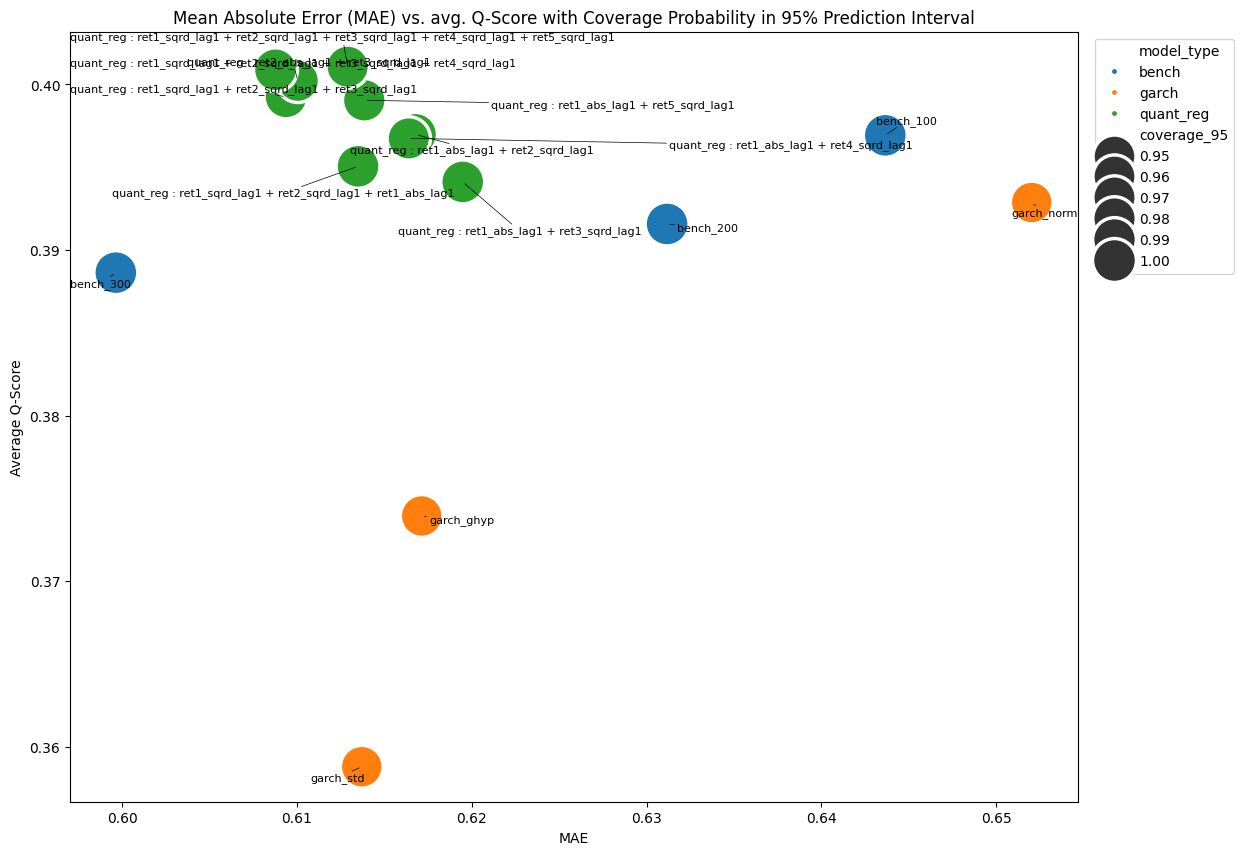

In [233]:
# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_1.head(15).copy()

# Add model type as column
df['model_type'] = 'bench'
df.loc[df.index.str.contains('quant_reg'), 'model_type'] = 'quant_reg'
df.loc[df.index.str.contains('garch'), 'model_type'] = 'garch'

# sort df alphabetically by model name
df = df.sort_index()

# Bubble plot using Seaborn
plt.figure(figsize=(13, 10))
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='model_type', 
                data=df, sizes=(100, 1000), size_norm=(0,1), legend='brief')

# Adding model names below the bubbles
texts = []
for model, row in df.iterrows():
    texts.append(plt.text(row['mae_q0.5'], row['avg_qscore'], model, 
                          ha='center', va='center', fontsize=8))
    
# Adjust text positions with increased space around text and points
adjust_text(texts, expand=(1.2,2), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# Customizing labels        
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('plots/dax_1ens_1overview_bubble_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### fcast horizon analysis

In [216]:
model_list = ['garch_std', 'garch_ghyp', 'garch_norm', 'bench_300', 'quant_reg : ret1_abs_lag1 + ret3_sqrd_lag1']

# list all csv files in folder that contain "weekly_fcasts" using os
files = [f for f in os.listdir(folder) if "weekly_fcasts" in f]

# Define the start and end dates
start_date = pd.Timestamp('2023-11-15')
end_date = pd.Timestamp('2024-02-14')
# Generate a list of weekly dates in UTC
fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tz_localize('CET').strftime('%Y-%m-%d').tolist()

res_dict_detailed = {}

for file_idx in range(len(files)):

    fname = f"dax_weekly_fcasts_{file_idx+1}.csv"
    # print(fname)
    df_fcast = pd.read_csv(f"{folder}/{fname}", index_col=['fcast_target_date'], parse_dates=True)

    fcast_date = fcast_dates_cet[file_idx]
    subm_timestamps = df_fcast.index.unique()
    df_truevals_weekly = df_truevals.loc[subm_timestamps]

    weekly_model_scores_dict = {}

    for model_name in model_list:

        df_fcast_model = df_fcast[df_fcast.model_name == model_name]
        df_fcast_model = df_fcast_model.drop(columns=['model_name'])

        df_scores = model_eval.eval_fcast_qscore_dax(df_fcast_model, df_truevals_weekly, subm_timestamps, quantiles)
        df_scores['coverage_50'] = df_truevals_weekly.iloc[:,0].between(df_fcast_model.iloc[:, 1], df_fcast_model.iloc[:, 3])
        df_scores['coverage_95'] = df_truevals_weekly.iloc[:,0].between(df_fcast_model.iloc[:, 0], df_fcast_model.iloc[:, 4])
        df_scores['mae_q0.5'] = np.abs(df_fcast_model.iloc[:, 2] - df_truevals_weekly.iloc[:,0])

        weekly_model_scores_dict[model_name] = df_scores

    res_dict_detailed[fcast_date] = weekly_model_scores_dict

In [217]:
input_dict = res_dict_detailed.copy()

model_scores_entire_period_dict = {}
model_avg_scores_entire_period_dict = {}

for model in model_list:
    scores_df_list = [week_dict[model] for week_dict in input_dict.values()]
    model_scores_entire_period_dict[model] = pd.concat(scores_df_list)

    # replace index of each df in scores_df_list with integers 0 to length
    scores_df_list = [df.reset_index(drop=True) for df in scores_df_list]
    # remove cols not containing 'q-score'
    scores_df_list = [df.loc[:, df.columns.str.contains('q-score')] for df in scores_df_list]
    temp_df = pd.concat(scores_df_list).groupby(level=0).mean()
    model_avg_scores_entire_period_dict[model] = temp_df

C:\Users\ytl_c\AppData\Local\Temp\ipykernel_17992\4021731707.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


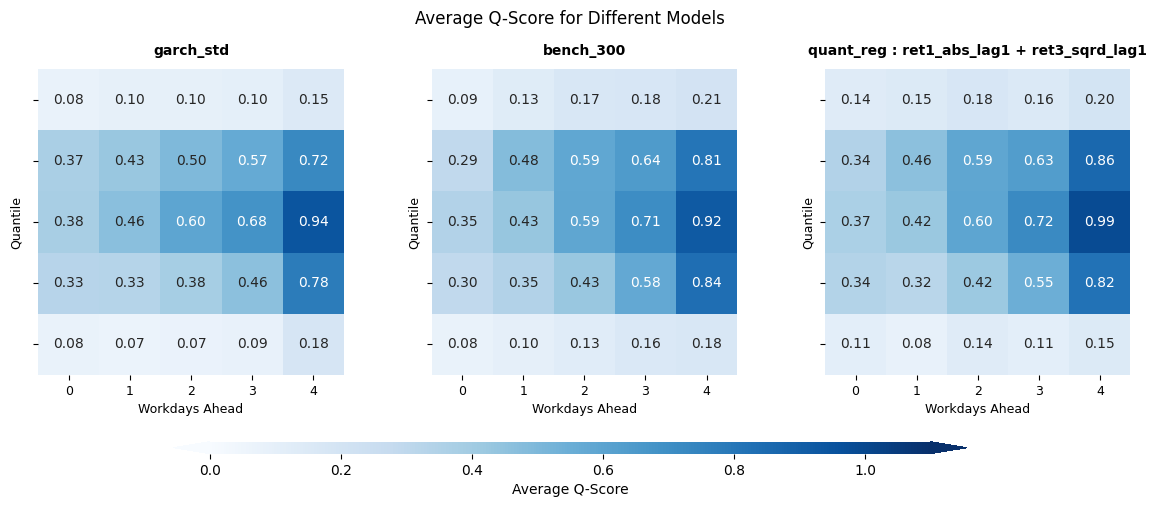

In [419]:
# Define xticks
quants = [0.025, 0.25, 0.5, 0.75, 0.975]

model_list = ['garch_std', 'bench_300', 'quant_reg : ret1_abs_lag1 + ret3_sqrd_lag1']
cmap_choice = 'Blues'  # Change the colormap to 'Blues'

# Create subplots
height = 4
n_models = len(model_list)
fig, axes = plt.subplots(1, n_models, figsize=(n_models * height, height), sharey=True)

# Adjust the position and size of the colorbar
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # left bot width height

# Loop through model list
for i, model in enumerate(model_list):

    table = model_avg_scores_entire_period_dict[model].T
    sns.heatmap(table, annot=True, fmt=".2f", cmap=cmap_choice,
                cbar_kws={'label': 'Average Q-Score', 'orientation': 'horizontal', 'extend': 'both'},
                square=True, yticklabels=quants, ax=axes[i], cbar_ax=cbar_ax, vmin=0, vmax=1.1)

    label_size = 9
    axes[i].set_xlabel('Workdays Ahead', fontsize=label_size)
    axes[i].set_ylabel('Quantile', fontsize=label_size)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=label_size)  # Set xtick labels fontsize
    axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=label_size)  # Set ytick labels fontsize

    axes[i].set_title(f'{model}', fontsize=10, y=1.02, fontweight='bold')

plt.suptitle('Average Q-Score for Different Models', fontsize=12, y=1.01)  # Adjust suptitle fontsize and position
plt.tight_layout()
# save
plt.savefig('plots/dax_1ens_1overview_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

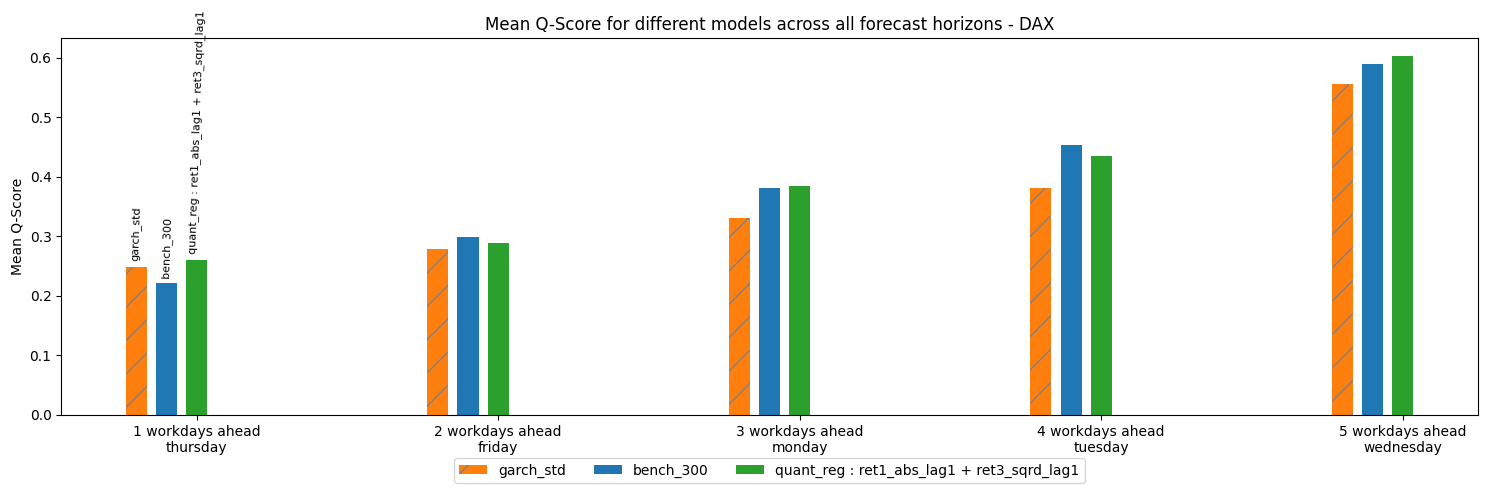

In [420]:
plt.figure(figsize=(15, 5))

fcast_hor = [1,2,3,4,5]

# mark fcast dates
start_date = pd.Timestamp('2023-11-15')
end_date = pd.Timestamp('2024-02-14')
fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tolist()

# Define color list = default blue, orange, green
colorlist = {'bench' : 'tab:blue', 
             'garch' : 'tab:orange', 
             'quant' : 'tab:green'}

hatchstyle = {'garch_std' : '/',
              'garch_ghyp' : '.',
              'garch_norm' : None}

for i, model in enumerate(model_list):

    model_df = model_avg_scores_entire_period_dict[model].mean(axis=1)
    model_type = model.split('_')[0]
    color = colorlist[model_type]
    if 'garch' in model: 
        plt.bar(np.arange(len(fcast_hor)) + i*0.1 + 0.3, model_df, width=0.07, label=model, color=color,
                hatch = hatchstyle[model], edgecolor='grey', lw=0, alpha=1)
    else : 
        plt.bar(np.arange(len(fcast_hor)) + i*0.1 + 0.3, model_df, width=0.07, label=model, color=color)

    # Add model names above bars
    for j, score in enumerate(model_df):
        if j > 0 : break
        if i < 3 : plt.text(j + i * 0.1 + 0.3, score + 0.01, model, ha='center', va='bottom', fontsize=8, rotation=88)

# custom xlabels
xlabels = [f'{hor} workdays ahead' for hor in fcast_hor]
labels_add = ['thursday', 'friday', 'monday',
              'tuesday', 'wednesday']

# add labels_add behind xlabels and put \n in between
xlabels = [f'{x}\n{labels_add[i]}' for i, x in enumerate(xlabels)]
plt.xticks(ticks=np.arange(len(fcast_hor))+0.5, labels=xlabels)

plt.ylabel('Mean Q-Score')
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=5)
plt.title('Mean Q-Score for different models across all forecast horizons - DAX')
plt.tight_layout()

plt.savefig('plots/dax_1ens_1overview_fcasthor_barplot.pdf', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ytl_c\AppData\Local\Temp\ipykernel_17992\3064472335.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = mpl.cm.get_cmap('GnBu')


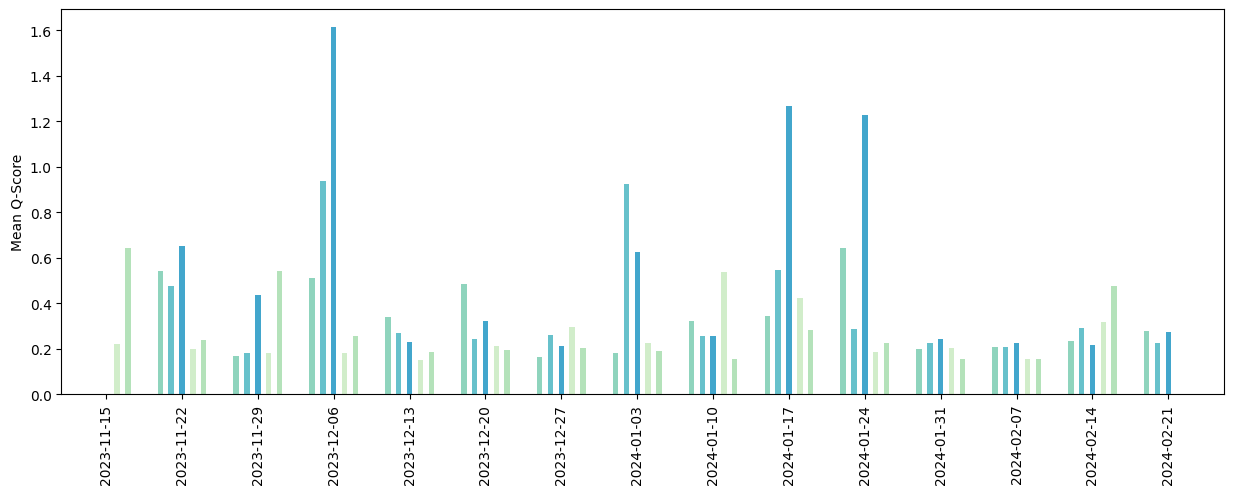

In [343]:
plt.figure(figsize=(15, 5))

fcast_hor = [1,2,5,6,7]

# mark fcast dates
start_date = pd.Timestamp('2023-11-15')
end_date = pd.Timestamp('2024-02-14')
fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tolist()

# colormap = mpl.colormaps.get_cmap('PuBu')
colormap = mpl.cm.get_cmap('GnBu')

model = 'garch_std'
for fcast_idx, fcast_date in enumerate(fcast_dates_cet):

    subm_timestamps = [(fcast_date + pd.Timedelta(days=i)) for i in fcast_hor]
    model_df = model_scores_entire_period_dict[model].iloc[:,:5].mean(axis=1)
    model_df.index = [x.replace(tzinfo=None) for x in model_df.index]
    model_df = model_df.loc[model_df.index.isin(subm_timestamps)]
    
    # Plot bars with specific colors
    for i, timestamp in enumerate(model_df.index):
        perc = (i+2)/(len(model_df)+4)
        plt.bar(timestamp, model_df[timestamp], width=0.5, color=colormap(perc), alpha=1)

# # mark fcast dates
# for fcast_date in fcast_dates_cet:
#     plt.axvline(fcast_date, color='grey', linestyle='--', zorder=0)
    
# custom x ticks as fcast_dates_cet
# add one more date to the end for the last bar
fcast_dates_cet.append(fcast_dates_cet[-1] + pd.Timedelta(days=7))
fcast_dates_cet_str = [date.strftime('%Y-%m-%d') for date in fcast_dates_cet]
plt.xticks(ticks=fcast_dates_cet, labels=fcast_dates_cet_str, rotation=90)

plt.ylabel('Mean Q-Score')
plt.show()

### 2 Ensemble ( partial )

In [166]:
def eval_ensembles(ens_size, model_subset):

    combis = list(itertools.combinations(model_subset, ens_size))
    # filter out all ensembles with repeating models
    combis = [combi for combi in combis if len(set(combi)) == ens_size]
    print(len(combis))
    
    # list all csv files in folder that contain "weekly_fcasts" using os
    files = [f for f in os.listdir(folder) if "weekly_fcasts" in f]

    all_combi_names = [f"ens | {', '.join(combi)}" if len(combi)>1 else combi[0] for combi in combis]
    res_dict = {}

    for file_idx in range(len(files)):

        fname = f"dax_weekly_fcasts_{file_idx+1}.csv"
        print(fname)
        df_fcast = pd.read_csv(f"{folder}/{fname}", index_col=['fcast_target_date'], parse_dates=True)

        fcast_date = fcast_dates_cet[file_idx]
        subm_timestamps = df_fcast.index.unique()
        df_truevals_weekly = df_truevals.loc[subm_timestamps]

        weekly_scores_df = pd.DataFrame(index=all_combi_names,
                                        columns=['avg_qscore', 'avg_qscore_0.025', 'avg_qscore_0.25', 
                                                'avg_qscore_0.5', 'avg_qscore_0.75', 'avg_qscore_0.975',
                                                'coverage_50', 'coverage_95', 'mae_q0.5'])

        for combi_idx, combi in enumerate(combis):
            
            model_name = f"ens | {', '.join(combi)}" if ens_size > 1 else combi[0]
            pred_list = [df_fcast[df_fcast['model_name'] == model] for model in combi]
            pred_vals = [df.iloc[:,:-1].values for df in pred_list]
            # Take the average of the quantiles across all models in the ensemble
            ens_pred_df = pred_list[0].iloc[:,:-1].copy()
            ens_pred_df.iloc[:, :] = np.mean(pred_vals, axis=0)

            df_scores = model_eval.eval_fcast_qscore_dax(ens_pred_df, df_truevals_weekly, subm_timestamps, quantiles)

            weekly_scores_df.loc[model_name, 'avg_qscore'] = df_scores.values.mean()
            weekly_scores_df.loc[model_name, 'avg_qscore_0.025'] = df_scores.mean(axis=0).iloc[0]
            weekly_scores_df.loc[model_name, 'avg_qscore_0.25'] = df_scores.mean(axis=0).iloc[1]
            weekly_scores_df.loc[model_name, 'avg_qscore_0.5'] = df_scores.mean(axis=0).iloc[2]
            weekly_scores_df.loc[model_name, 'avg_qscore_0.75'] = df_scores.mean(axis=0).iloc[3]
            weekly_scores_df.loc[model_name, 'avg_qscore_0.975'] = df_scores.mean(axis=0).iloc[4]
            weekly_scores_df.loc[model_name, 'coverage_50'] = df_truevals_weekly.iloc[:,0].between(ens_pred_df.iloc[:, 1], ens_pred_df.iloc[:, 3]).mean()
            weekly_scores_df.loc[model_name, 'coverage_95'] = df_truevals_weekly.iloc[:,0].between(ens_pred_df.iloc[:, 0], ens_pred_df.iloc[:, 4]).mean()
            weekly_scores_df.loc[model_name, 'mae_q0.5'] = mean_absolute_error(ens_pred_df.iloc[:, 2], df_truevals_weekly.iloc[:,0])

        res_dict[fcast_date] = weekly_scores_df

    return res_dict

In [167]:
res_dict_2 = eval_ensembles(2, res_df_1.head(15).index)

105
dax_weekly_fcasts_1.csv
dax_weekly_fcasts_2.csv
dax_weekly_fcasts_3.csv
dax_weekly_fcasts_4.csv
dax_weekly_fcasts_5.csv
dax_weekly_fcasts_6.csv
dax_weekly_fcasts_7.csv
dax_weekly_fcasts_8.csv
dax_weekly_fcasts_9.csv
dax_weekly_fcasts_10.csv
dax_weekly_fcasts_11.csv
dax_weekly_fcasts_12.csv
dax_weekly_fcasts_13.csv
dax_weekly_fcasts_14.csv


In [168]:
res_df_2 = pd.concat(res_dict_2.values())
res_df_2 = res_df_2.groupby(res_df_2.index).mean().sort_values(by='avg_qscore', ascending=True)
print(res_df_2.shape)
display(res_df_2.head(10).style.highlight_min(color = 'yellow', axis=0))

# res_df.to_csv("2024_03_28 2 model ensemble scores.csv")

(105, 9)


,avg_qscore,avg_qscore_0.025,avg_qscore_0.25,avg_qscore_0.5,avg_qscore_0.75,avg_qscore_0.975,coverage_50,coverage_95,mae_q0.5
"ens | garch_std, garch_ghyp",0.362475,0.101656,0.520780,0.607904,0.467380,0.114657,0.585714,0.928571,0.607904
"ens | garch_ghyp, bench_300",0.365679,0.124450,0.544083,0.600073,0.463329,0.096459,0.685714,1.000000,0.600073
"ens | garch_std, bench_300",0.366205,0.124343,0.534193,0.606674,0.462335,0.103484,0.714286,1.000000,0.606674
"ens | garch_std, quant_reg : ret1_sqrd_lag1 + ret2_sqrd_lag1 + ret1_abs_lag1",0.369086,0.133973,0.536875,0.612400,0.459507,0.102672,0.700000,0.985714,0.612400
"ens | garch_std, bench_100",0.369130,0.113793,0.546887,0.617347,0.473614,0.094007,0.657143,0.985714,0.617347
"ens | garch_std, quant_reg : ret1_abs_lag1 + ret3_sqrd_lag1",0.369400,0.129016,0.537963,0.616597,0.460751,0.102672,0.671429,0.985714,0.616597
"ens | garch_std, garch_norm",0.369453,0.105692,0.539320,0.617787,0.470273,0.114192,0.571429,0.942857,0.617787
"ens | garch_ghyp, quant_reg : ret1_sqrd_lag1 + ret2_sqrd_lag1 + ret1_abs_lag1",0.369776,0.134081,0.545499,0.607662,0.456734,0.104906,0.657143,0.985714,0.607662
"ens | garch_std, bench_200",0.369798,0.121014,0.544130,0.619979,0.468193,0.095675,0.642857,0.985714,0.619979
"ens | garch_std, quant_reg : ret1_abs_lag1 + ret2_sqrd_lag1",0.370089,0.134184,0.538691,0.614825,0.457927,0.104820,0.700000,0.985714,0.614825


#### plot all

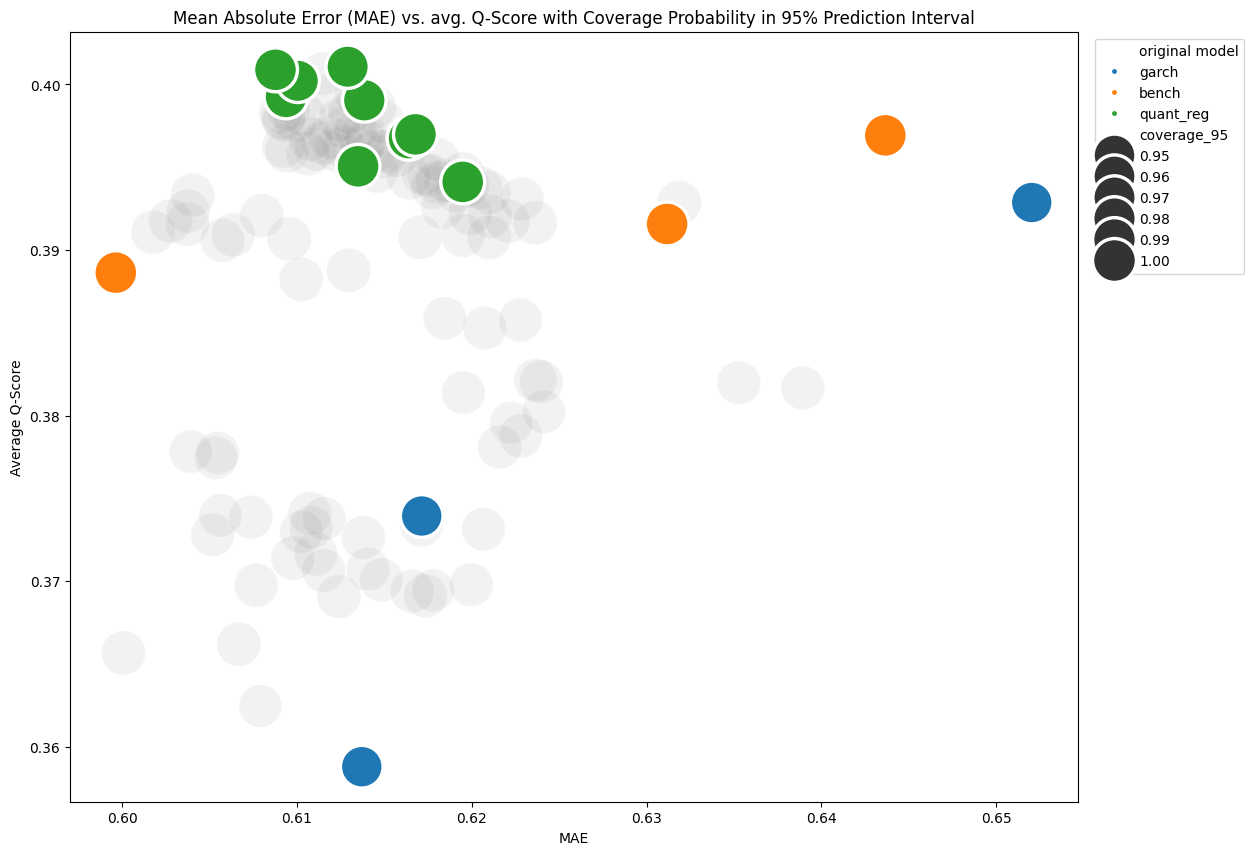

In [169]:
# Overview of where single models are
df = res_df_2.copy()

# Bubble plot using Seaborn for all non-grey dots
plt.figure(figsize=(13, 10))

# Plot grey dots separately with transparency
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95',
                data=df, sizes=(100, 1000), size_norm=(0,1), 
                legend=False, color='grey', alpha=0.1)

df = res_df_1.head(15).copy()

# Add model type as column
colname = 'original model'
df[colname] = 'bench'
df.loc[df.index.str.contains('quant_reg'), colname] = 'quant_reg'
df.loc[df.index.str.contains('garch'), colname] = 'garch'

# Bubble plot using Seaborn
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue=colname, 
                data=df, sizes=(100, 1000), size_norm=(0,1), legend='brief')

# Customizing labels
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('plots/dax_2ens_1overview_bubble_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [170]:
# # overview of where ens models with only 1 model type are

# # Sample DataFrame (Replace this with your actual DataFrame)
# df = res_df_2.copy()

# temp_name = '-'
# # List of model types
# model_types = ['bench', 'garch', 'quant_reg']
# temp = [list(set([model_type for model_type in model_types if model_type in index])) for index in df.index]
# df['ensembles containing only'] = [item[0] if len(item)==1 else temp_name for item in temp]

# # sort df alphabetically by model_type
# df = df.sort_values(by='ensembles containing only')

# # # Define custom palette
# # custom_palette = {temp_name: 'grey'}
# custom_palette = {}
# default_palette = sns.color_palette()
# for idx, model_type in enumerate(sorted(model_types)):
#     custom_palette[model_type] = default_palette[idx]

# # Bubble plot using Seaborn for all non-grey dots
# plt.figure(figsize=(13, 10))

# # Plot grey dots separately with transparency
# sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95',
#                 data=df[df['ensembles containing only'] == temp_name], sizes=(100, 1000), size_norm=(0,1), 
#                 legend=False, color='grey', alpha=0.1)

# sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='ensembles containing only', 
#                 data=df[df['ensembles containing only'] != temp_name], sizes=(100, 1000), size_norm=(0,1), 
#                 legend='brief', palette=custom_palette)

# # Customizing labels
# plt.xlabel('MAE')
# plt.ylabel('Average Q-Score')
# plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# # Placing legend outside the plot area on the top right
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# plt.savefig('plots/dax_2ens_1overview_bubble_plot.pdf', dpi=300, bbox_inches='tight')
# plt.show()

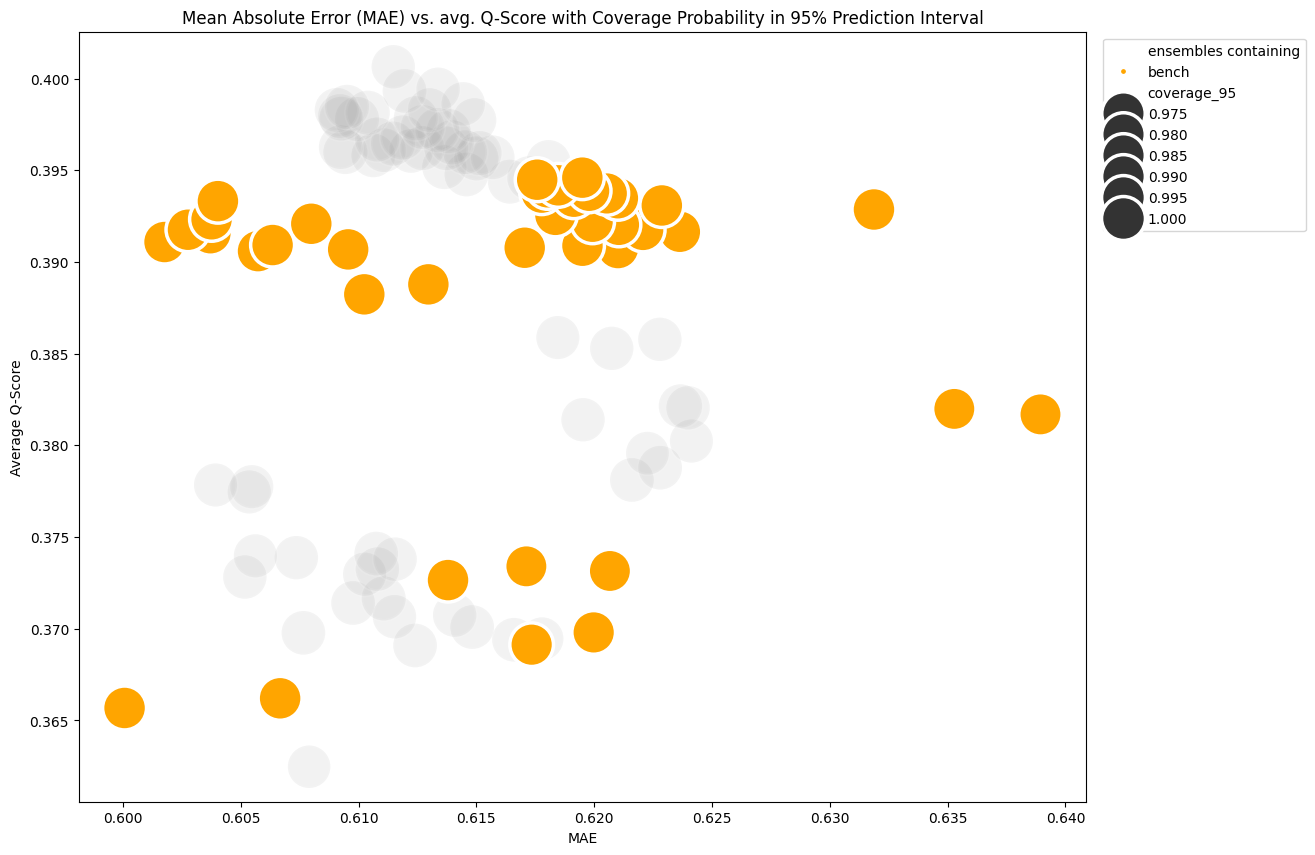

In [171]:
# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_2.copy()

# List of model types
model_types = ['bench', 'garch', 'quant_reg']

for idx, model_type in enumerate(model_types):

    df['ensembles containing'] = [f'{model_type}' if model_type in index else 'others' for index in df.index]
    
    # Define colors for contains_modeltype and others
    custom_palette = {f'{model_type}': 'orange'}

    # Bubble plot using Seaborn for all non-grey dots
    plt.figure(figsize=(13, 10))

    # Plot grey dots separately with transparency
    sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95',
                    data=df[df['ensembles containing'] != f'{model_type}'], sizes=(100, 1000), size_norm=(0,1), 
                    legend=False, color='grey', alpha=0.1)
    
    sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='ensembles containing', 
                data=df[df['ensembles containing'] == f'{model_type}'], sizes=(100, 1000), size_norm=(0,1), 
                legend='brief', palette=custom_palette)

    # Customizing labels        
    plt.xlabel('MAE')
    plt.ylabel('Average Q-Score')
    plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

    # Placing legend outside the plot area on the top right
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.savefig(f'plots/dax_2ens_{model_type}_bubble_plot.pdf', dpi=300, bbox_inches='tight')
    if idx > 0: plt.close()
    else : plt.show()

#### plot top

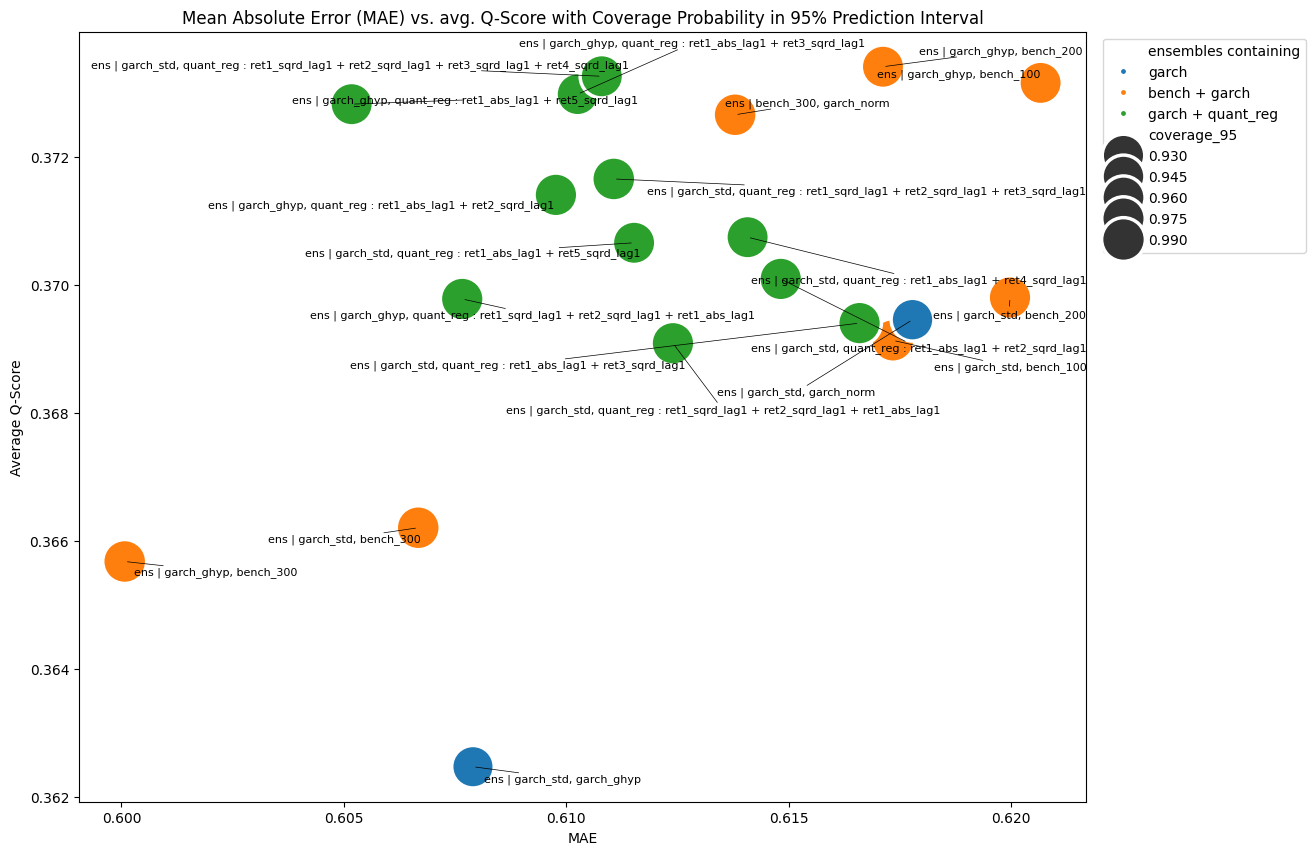

In [172]:
# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_2.iloc[:20].copy()

# List of model types
model_types = ['bench', 'garch', 'quant_reg']

# Extract model types from index and create model type column
df['ensembles containing'] = [
    ' + '.join([model_type for model_type in model_types if model_type in index]) if any(model_type in index for model_type in model_types)
    else 'benchmark'
    for index in df.index]

# Bubble plot using Seaborn
plt.figure(figsize=(13, 10))
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='ensembles containing', 
                data=df, sizes=(100, 1000), size_norm=(0,1), legend='brief')

# Adding model names below the bubbles
texts = []
for model, row in df.iterrows():
    texts.append(plt.text(row['mae_q0.5'], row['avg_qscore'], model, 
                          ha='center', va='center', fontsize=8))
    
# Adjust text positions with increased space around text and points
adjust_text(texts, expand=(1.2,2), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# Customizing labels        
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('plots/dax_2ens_top10_bubble_plot_a.pdf', dpi=300, bbox_inches='tight')
plt.show()

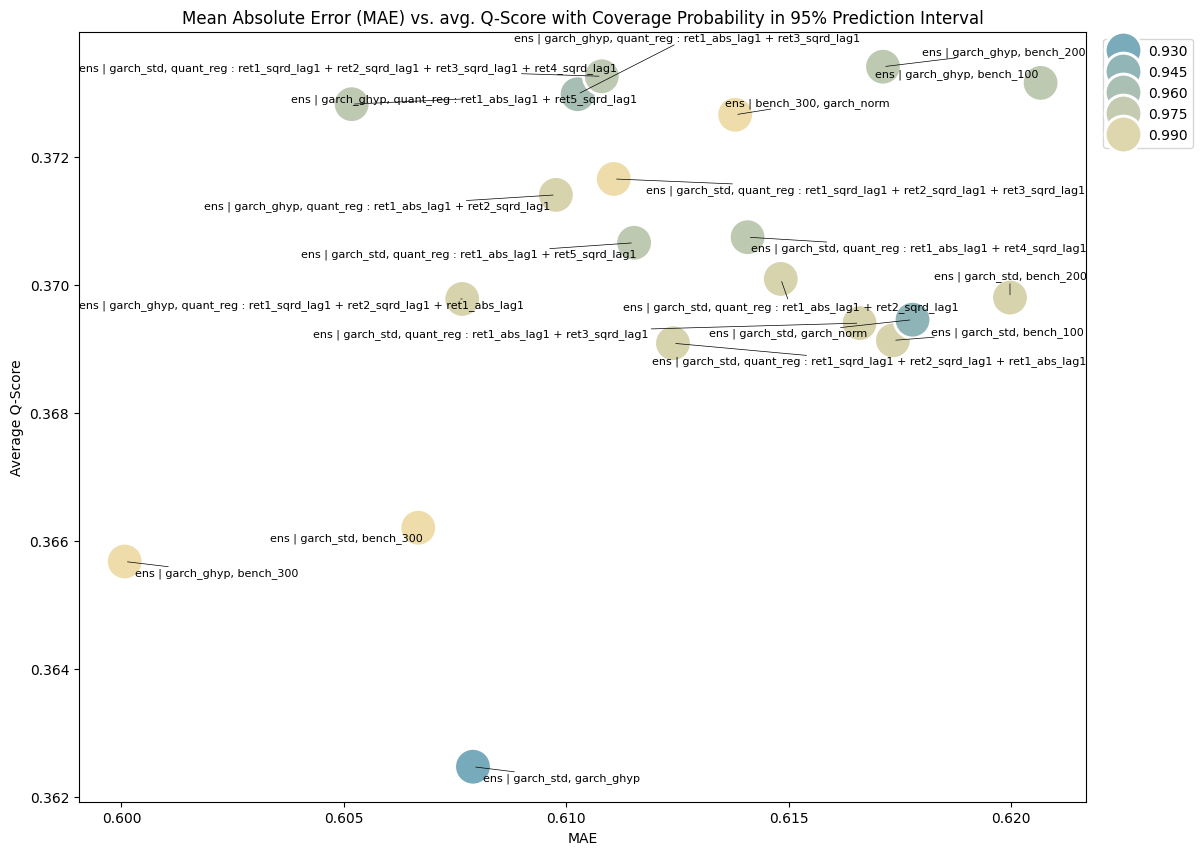

In [190]:
# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_2.iloc[:20].copy()

# List of model types
model_types = ['bench', 'garch', 'quant_reg']

# Extract model types from index and create model type column
df['model_type'] = [
    ' + '.join([model_type for model_type in model_types if model_type in index]) if any(model_type in index for model_type in model_types)
    else 'benchmark'
    for index in df.index]

custom_palette = sns.color_palette("blend:#7AB,#EDA", as_cmap=True)

# Bubble plot using Seaborn
plt.figure(figsize=(13, 10))
sns.scatterplot(x='mae_q0.5', y='avg_qscore', hue='coverage_95', s=700,
                data=df, legend='brief', palette=custom_palette)

# Adding model names below the bubbles
texts = []
for model, row in df.iterrows():
    texts.append(plt.text(row['mae_q0.5'], row['avg_qscore'], model, 
                          ha='center', va='center', fontsize=8))
    
# Adjust text positions with increased space around text and points
adjust_text(texts, expand=(1.2,2), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# Customizing labels        
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('plots/dax_2ens_top10_bubble_plot_b.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 3 Ensemble ( partial )

In [178]:
res_dict_3 = eval_ensembles(3, res_df_1.head(15).index)

455
dax_weekly_fcasts_1.csv
dax_weekly_fcasts_2.csv
dax_weekly_fcasts_3.csv
dax_weekly_fcasts_4.csv
dax_weekly_fcasts_5.csv
dax_weekly_fcasts_6.csv
dax_weekly_fcasts_7.csv
dax_weekly_fcasts_8.csv
dax_weekly_fcasts_9.csv
dax_weekly_fcasts_10.csv
dax_weekly_fcasts_11.csv
dax_weekly_fcasts_12.csv
dax_weekly_fcasts_13.csv
dax_weekly_fcasts_14.csv


In [179]:
# # save to pickle
# with open(f"{folder}/eval_3ensembles.pickle", "wb") as f:
#     pickle.dump(res_dict_3, f)

# # read from pickle
# with open("2024-03-28_14-29-58 final all models/eval_2ensembles.pickle", "rb") as f:
#     res_dict_2 = pickle.load(f)
    
res_df_3 = pd.concat(res_dict_3.values())
res_df_3 = res_df_3.groupby(res_df_3.index).mean().sort_values(by='avg_qscore', ascending=True)
print(res_df_3.shape)
display(res_df_3.head(10).style.highlight_min(color = 'yellow', axis=0))

(455, 9)


,avg_qscore,avg_qscore_0.025,avg_qscore_0.25,avg_qscore_0.5,avg_qscore_0.75,avg_qscore_0.975,coverage_50,coverage_95,mae_q0.5
"ens | garch_std, garch_ghyp, bench_300",0.360249,0.114213,0.531326,0.603668,0.458643,0.093396,0.628571,0.985714,0.603668
"ens | garch_std, garch_ghyp, quant_reg : ret1_sqrd_lag1 + ret2_sqrd_lag1 + ret1_abs_lag1",0.363597,0.120634,0.533264,0.607764,0.455243,0.101083,0.642857,0.985714,0.607764
"ens | garch_std, bench_300, garch_norm",0.364520,0.115933,0.542894,0.609748,0.460337,0.093691,0.628571,0.985714,0.609748
"ens | garch_std, garch_ghyp, quant_reg : ret1_abs_lag1 + ret2_sqrd_lag1",0.364544,0.120774,0.534475,0.609102,0.455412,0.102956,0.642857,0.971429,0.609102
"ens | garch_std, garch_ghyp, bench_100",0.365247,0.107180,0.539789,0.611680,0.469498,0.098086,0.628571,0.971429,0.611680
"ens | garch_std, garch_ghyp, quant_reg : ret1_abs_lag1 + ret5_sqrd_lag1",0.365527,0.118843,0.538747,0.605245,0.452703,0.112097,0.657143,0.971429,0.605245
"ens | garch_std, garch_ghyp, quant_reg : ret1_abs_lag1 + ret3_sqrd_lag1",0.365712,0.117328,0.533989,0.610283,0.461457,0.105503,0.642857,0.957143,0.610283
"ens | garch_std, garch_ghyp, bench_200",0.365940,0.111994,0.537951,0.612326,0.467943,0.099486,0.614286,0.971429,0.612326
"ens | garch_std, garch_ghyp, quant_reg : ret1_sqrd_lag1 + ret2_sqrd_lag1 + ret3_sqrd_lag1",0.366343,0.120582,0.539569,0.606599,0.464428,0.100536,0.657143,0.971429,0.606599
"ens | garch_std, garch_ghyp, quant_reg : ret1_abs_lag1 + ret4_sqrd_lag1",0.366508,0.118923,0.534736,0.607647,0.457393,0.113840,0.642857,0.971429,0.607647


#### plot top & all

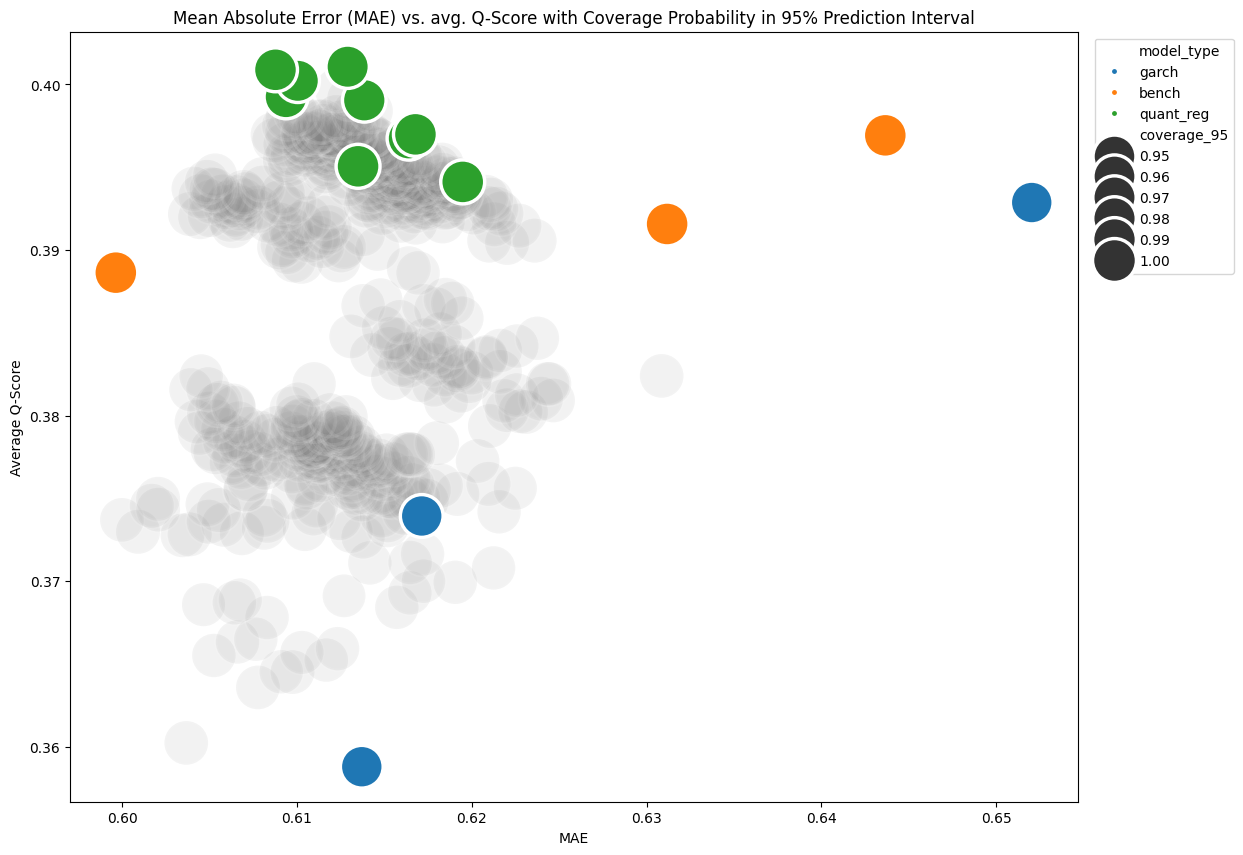

In [187]:
# Bubble plot using Seaborn
plt.figure(figsize=(13, 10))

df_temp = res_df_3.copy()
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95',
                data=df_temp, sizes=(100, 1000), size_norm=(0,1), 
                legend=False, color='grey', alpha=0.1)

df = res_df_1.head(15).copy()
# Add model type as column
df['model_type'] = 'bench'
df.loc[df.index.str.contains('quant_reg'), 'model_type'] = 'quant_reg'
df.loc[df.index.str.contains('garch'), 'model_type'] = 'garch'
# Bubble plot using Seaborn
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='model_type', 
                data=df, sizes=(100, 1000), size_norm=(0,1), legend='brief')

# Customizing labels        
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('plots/dax_3ens_overview_bubble_plot_a.pdf', dpi=300, bbox_inches='tight')
plt.show()

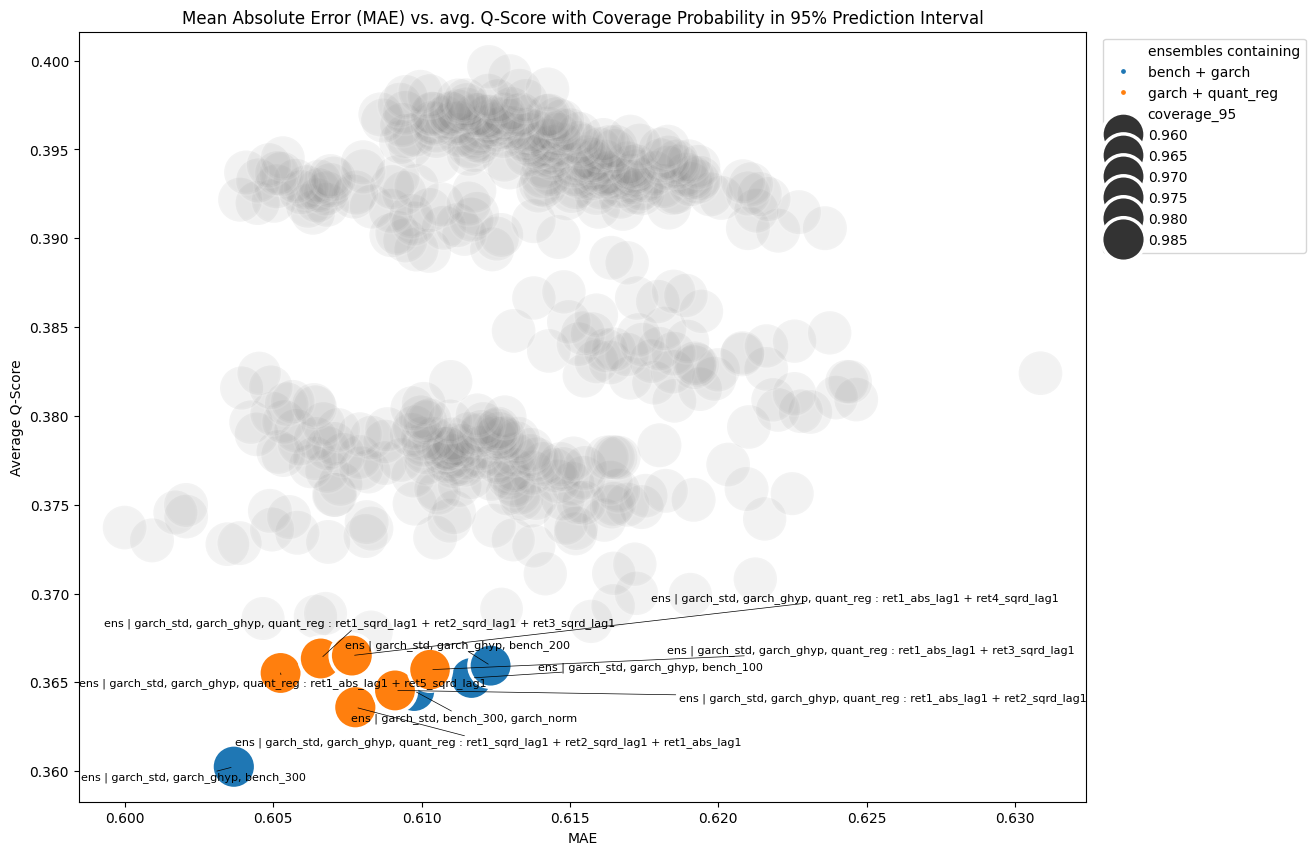

In [189]:
# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_3.iloc[:10].copy()
# List of model types
model_types = ['bench', 'garch', 'quant_reg']

# Extract model types from index and create model type column
df['ensembles containing'] = [
    ' + '.join([model_type for model_type in model_types if model_type in index]) if any(model_type in index for model_type in model_types)
    else 'benchmark'
    for index in df.index]

# Bubble plot using Seaborn
plt.figure(figsize=(13, 10))

df_temp = res_df_3.copy()
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95',
                data=df_temp, sizes=(100, 1000), size_norm=(0,1), 
                legend=False, color='grey', alpha=0.1)

sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='ensembles containing', 
                data=df, sizes=(100, 1000), size_norm=(0,1), legend='brief')

# Adding model names below the bubbles
texts = []
for model, row in df.iterrows():
    texts.append(plt.text(row['mae_q0.5'], row['avg_qscore'], model, 
                          ha='center', va='center', fontsize=8))
    
# Adjust text positions with increased space around text and points
adjust_text(texts, expand=(1.2,2), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# Customizing labels        
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('plots/dax_3ens_top10_bubble_plot_a.pdf', dpi=300, bbox_inches='tight')
plt.show()

### custom ensembles ie 3+

In [174]:
def eval_custom_ensembles(ens_list):

    combis = ens_list
    print(len(combis))
    
    # list all csv files in folder that contain "weekly_fcasts" using os
    files = [f for f in os.listdir(folder) if "weekly_fcasts" in f]
    
    all_combi_names = [f"ens | {', '.join(combi)}" if len(combi)>1 else combi[0] for combi in combis]
    res_dict = {}

    for file_idx in range(len(files)):

        fname = f"dax_weekly_fcasts_{file_idx+1}.csv"
        print(fname)
        df_fcast = pd.read_csv(f"{folder}/{fname}", index_col=['fcast_target_date'], parse_dates=True)

        fcast_date = fcast_dates_cet[file_idx]
        subm_timestamps = df_fcast.index.unique()
        df_truevals_weekly = df_truevals.loc[subm_timestamps]

        weekly_scores_df = pd.DataFrame(index=all_combi_names,
                                        columns=['avg_qscore', 'avg_qscore_0.025', 'avg_qscore_0.25', 
                                                'avg_qscore_0.5', 'avg_qscore_0.75', 'avg_qscore_0.975',
                                                'coverage_50', 'coverage_95', 'mae_q0.5'])

        for combi_idx, combi in enumerate(combis):
            
            model_name = f"ens | {', '.join(combi)}" if len(combi)>1 else combi[0]
            pred_list = [df_fcast[df_fcast['model_name'] == model] for model in combi]
            pred_vals = [df.iloc[:,:-1].values for df in pred_list]
            # Take the average of the quantiles across all models in the ensemble
            ens_pred_df = pred_list[0].iloc[:,:-1].copy()
            ens_pred_df.iloc[:, :] = np.mean(pred_vals, axis=0)

            df_scores = model_eval.eval_fcast_qscore_dax(ens_pred_df, df_truevals_weekly, subm_timestamps, quantiles)

            weekly_scores_df.loc[model_name, 'avg_qscore'] = df_scores.values.mean()
            weekly_scores_df.loc[model_name, 'avg_qscore_0.025'] = df_scores.mean(axis=0).iloc[0]
            weekly_scores_df.loc[model_name, 'avg_qscore_0.25'] = df_scores.mean(axis=0).iloc[1]
            weekly_scores_df.loc[model_name, 'avg_qscore_0.5'] = df_scores.mean(axis=0).iloc[2]
            weekly_scores_df.loc[model_name, 'avg_qscore_0.75'] = df_scores.mean(axis=0).iloc[3]
            weekly_scores_df.loc[model_name, 'avg_qscore_0.975'] = df_scores.mean(axis=0).iloc[4]
            weekly_scores_df.loc[model_name, 'coverage_50'] = df_truevals_weekly.iloc[:,0].between(ens_pred_df.iloc[:, 1], ens_pred_df.iloc[:, 3]).mean()
            weekly_scores_df.loc[model_name, 'coverage_95'] = df_truevals_weekly.iloc[:,0].between(ens_pred_df.iloc[:, 0], ens_pred_df.iloc[:, 4]).mean()
            weekly_scores_df.loc[model_name, 'mae_q0.5'] = mean_absolute_error(ens_pred_df.iloc[:, 2], df_truevals_weekly.iloc[:,0])

        res_dict[fcast_date] = weekly_scores_df

    return res_dict

#### custom ens list

In [194]:
model_lists = [['garch_std'],['garch_ghyp'],['bench_300'], # best single models
               
               # top 2ensembles
               ['garch_std', 'garch_ghyp'], 
               ['garch_ghyp', 'bench_300'],
               ['garch_std', 'bench_300'],
               ['garch_std', 'quant_reg : ret1_sqrd_lag1 + ret2_sqrd_lag1 + ret1_abs_lag1'],
               ['garch_std', 'quant_reg : ret1_abs_lag1 + ret3_sqrd_lag1'],

               # try 3ensembles
               ['garch_std', 'garch_ghyp', 'bench_300'],
               ['garch_std', 'garch_ghyp', 'quant_reg : ret1_sqrd_lag1 + ret2_sqrd_lag1 + ret1_abs_lag1'],

                # try 4/5 ensembles
               ['garch_std', 'garch_ghyp', 'bench_300', 'quant_reg : ret1_abs_lag1 + ret3_sqrd_lag1']]

res_dict_custom = eval_custom_ensembles(model_lists)

11
dax_weekly_fcasts_1.csv
dax_weekly_fcasts_2.csv
dax_weekly_fcasts_3.csv
dax_weekly_fcasts_4.csv
dax_weekly_fcasts_5.csv
dax_weekly_fcasts_6.csv
dax_weekly_fcasts_7.csv
dax_weekly_fcasts_8.csv
dax_weekly_fcasts_9.csv
dax_weekly_fcasts_10.csv
dax_weekly_fcasts_11.csv
dax_weekly_fcasts_12.csv
dax_weekly_fcasts_13.csv
dax_weekly_fcasts_14.csv


In [195]:
res_df_custom = pd.concat(res_dict_custom.values())
res_df_custom = res_df_custom.groupby(res_df_custom.index).mean().sort_values(by='avg_qscore', ascending=True)
# res_df_custom.to_csv("2024_03_28 custom ensemble scores.csv")
display(res_df_custom.style.highlight_min(color = 'yellow', axis=0))

,avg_qscore,avg_qscore_0.025,avg_qscore_0.25,avg_qscore_0.5,avg_qscore_0.75,avg_qscore_0.975,coverage_50,coverage_95,mae_q0.5
garch_std,0.358811,0.106386,0.518098,0.613709,0.457355,0.098508,0.585714,0.942857,0.613709
"ens | garch_std, garch_ghyp, bench_300",0.360249,0.114213,0.531326,0.603668,0.458643,0.093396,0.628571,0.985714,0.603668
"ens | garch_std, garch_ghyp",0.362475,0.101656,0.520780,0.607904,0.467380,0.114657,0.585714,0.928571,0.607904
"ens | garch_std, garch_ghyp, quant_reg : ret1_sqrd_lag1 + ret2_sqrd_lag1 + ret1_abs_lag1",0.363597,0.120634,0.533264,0.607764,0.455243,0.101083,0.642857,0.985714,0.607764
"ens | garch_ghyp, bench_300",0.365679,0.124450,0.544083,0.600073,0.463329,0.096459,0.685714,1.000000,0.600073
"ens | garch_std, bench_300",0.366205,0.124343,0.534193,0.606674,0.462335,0.103484,0.714286,1.000000,0.606674
"ens | garch_std, garch_ghyp, bench_300, quant_reg : ret1_abs_lag1 + ret3_sqrd_lag1",0.366509,0.126733,0.540620,0.607622,0.459547,0.098024,0.671429,0.985714,0.607622
"ens | garch_std, quant_reg : ret1_sqrd_lag1 + ret2_sqrd_lag1 + ret1_abs_lag1",0.369086,0.133973,0.536875,0.612400,0.459507,0.102672,0.700000,0.985714,0.612400
"ens | garch_std, quant_reg : ret1_abs_lag1 + ret3_sqrd_lag1",0.369400,0.129016,0.537963,0.616597,0.460751,0.102672,0.671429,0.985714,0.616597
garch_ghyp,0.373948,0.098472,0.526108,0.617139,0.492589,0.135432,0.514286,0.942857,0.617139


#### plot

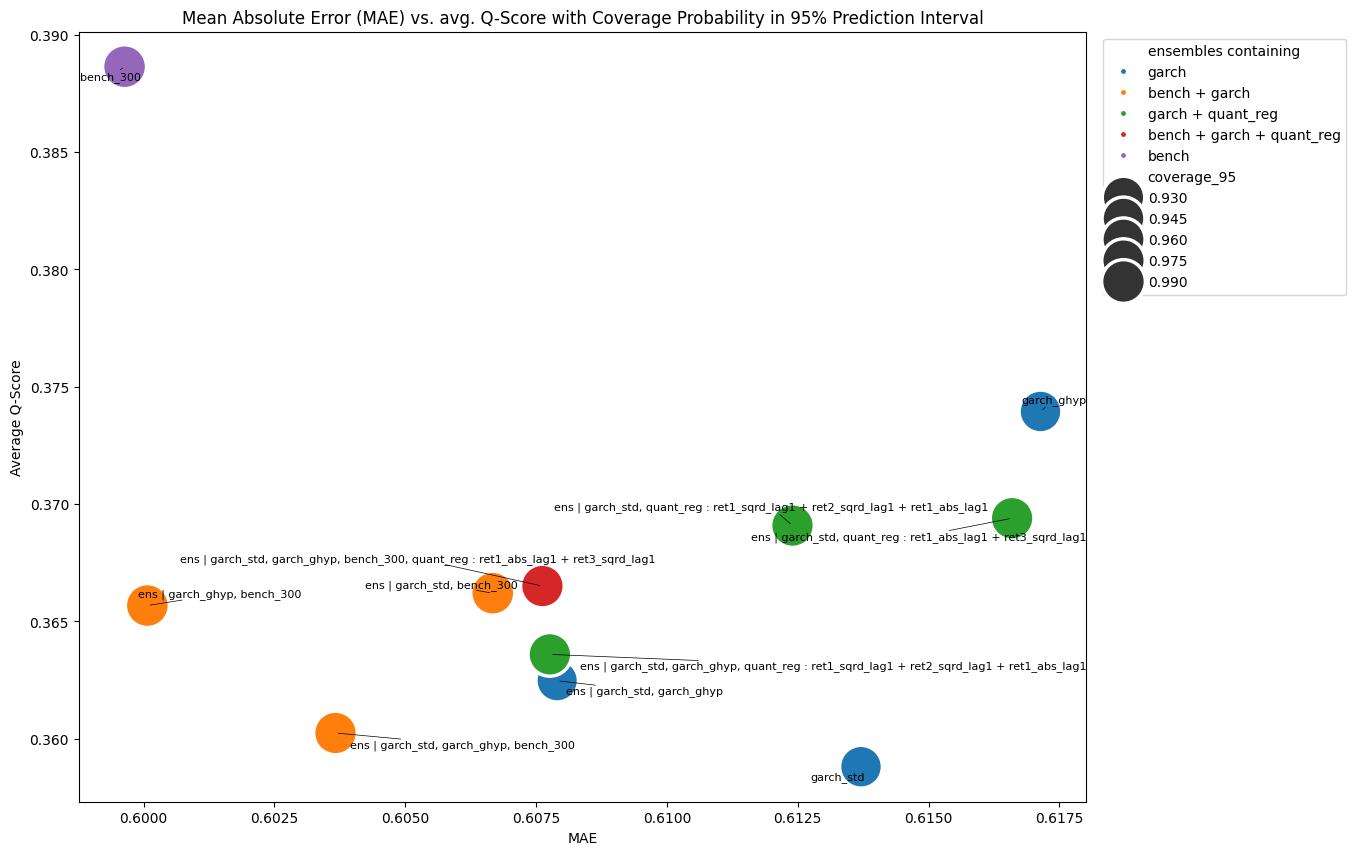

In [199]:
# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_custom.copy()

# List of model types
model_types = ['bench', 'garch', 'quant_reg']

# Extract model types from index and create model type column
df['ensembles containing'] = [
    ' + '.join([model_type for model_type in model_types if model_type in index]) if any(model_type in index for model_type in model_types)
    else '-'
    for index in df.index]

# Bubble plot using Seaborn
plt.figure(figsize=(13, 10))
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='ensembles containing', 
                data=df, sizes=(100, 1000), size_norm=(0,1), legend='brief')

# Adding model names below the bubbles
texts = []
for model, row in df.iterrows():
    texts.append(plt.text(row['mae_q0.5'], row['avg_qscore'], model, 
                          ha='center', va='center', fontsize=8))
    
# Adjust text positions with increased space around text and points
adjust_text(texts, expand=(1.2,2), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# Customizing labels        
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('plots/dax_ens_overview_bubble_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()